In [1]:
# Install required packages.
import os
import torch
os.environ['TORCH'] = torch.__version__
print(torch.__version__)

!pip install pyg_lib torch_scatter torch_sparse torch_cluster torch_spline_conv -f https://data.pyg.org/whl/torch-2.3.0+cu121.html
!pip install torch-geometric
!pip install rho-plus

2.2.0
Looking in links: https://data.pyg.org/whl/torch-2.3.0+cu121.html
^C
Traceback (most recent call last):
  File "/home/nicholas/anaconda3/bin/pip", line 7, in <module>
    from pip._internal.cli.main import main
  File "/home/nicholas/anaconda3/lib/python3.11/site-packages/pip/_internal/cli/main.py", line 10, in <module>
    from pip._internal.cli.autocompletion import autocomplete
  File "/home/nicholas/anaconda3/lib/python3.11/site-packages/pip/_internal/cli/autocompletion.py", line 10, in <module>
    from pip._internal.cli.main_parser import create_main_parser
  File "/home/nicholas/anaconda3/lib/python3.11/site-packages/pip/_internal/cli/main_parser.py", line 9, in <module>
    from pip._internal.build_env import get_runnable_pip
  File "/home/nicholas/anaconda3/lib/python3.11/site-packages/pip/_internal/build_env.py", line 19, in <module>
    from pip._internal.cli.spinners import open_spinner
  File "/home/nicholas/anaconda3/lib/python3.11/site-packages/pip/_internal/cli/sp

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import rho_plus as rp
import matplotlib.pyplot as plt

theme, cs = rp.mpl_setup(is_dark=False)

In [3]:
import torch
from torch_geometric.datasets import AQSOL

dataset = AQSOL('~/.cache/aqsol/')

print()
print(f'Dataset: {dataset}:')
print('====================')
print(f'Number of graphs: {len(dataset)}')
print(f'Number of features: {dataset.num_features}')
print(f'Number of classes: {dataset.num_classes}')
dataset.print_summary()

data = dataset[0]  # Get the first graph object.



# Gather some statistics about the first graph.
print(f'Number of nodes: {data.num_nodes}')
print(f'Number of edges: {data.num_edges}')
print(f'Average node degree: {data.num_edges / data.num_nodes:.2f}')
print(f'Has isolated nodes: {data.has_isolated_nodes()}')
print(f'Has self-loops: {data.has_self_loops()}')
print(f'Is undirected: {data.is_undirected()}')

/home/nicholas/anaconda3/envs/aviary/lib/python3.10/site-packages/torch_geometric/typing.py:72: UserWarning: An issue occurred while importing 'torch-scatter'. Disabling its usage. Stacktrace: /home/nicholas/anaconda3/envs/aviary/lib/python3.10/site-packages/torch_scatter/_version_cpu.so: undefined symbol: _ZN5torch3jit17parseSchemaOrNameERKSs
  warnings.warn(f"An issue occurred while importing 'torch-scatter'. "
/home/nicholas/anaconda3/envs/aviary/lib/python3.10/site-packages/torch_geometric/typing.py:110: UserWarning: An issue occurred while importing 'torch-sparse'. Disabling its usage. Stacktrace: /home/nicholas/anaconda3/envs/aviary/lib/python3.10/site-packages/torch_sparse/_version_cpu.so: undefined symbol: _ZN5torch3jit17parseSchemaOrNameERKSs
  warnings.warn(f"An issue occurred while importing 'torch-sparse'. "



Dataset: AQSOL(7836):
Number of graphs: 7836
Number of features: 1
Number of classes: 6334


/home/nicholas/anaconda3/envs/aviary/lib/python3.10/site-packages/torch_geometric/data/dataset.py:169: UserWarning: Found floating-point labels while calling `dataset.num_classes`. Returning the number of unique elements. Please make sure that this is expected before proceeding.
  warnings.warn("Found floating-point labels while calling "


AQSOL (#graphs=7836):
+------------+----------+----------+
|            |   #nodes |   #edges |
|------------+----------+----------|
| mean       |     15.4 |     30.7 |
| std        |      8.6 |     18.2 |
| min        |      2   |      2   |
| quantile25 |     10   |     18   |
| median     |     14   |     28   |
| quantile75 |     19   |     38   |
| max        |    156   |    306   |
+------------+----------+----------+
Number of nodes: 23
Number of edges: 42
Average node degree: 1.83
Has isolated nodes: True
Has self-loops: False
Is undirected: True


In [4]:
batch_size = 128
val_frac = 0.1

In [5]:
from torch.utils.data import Dataset, DataLoader, random_split, TensorDataset
train_ds, val_ds = random_split(dataset, [1 - val_frac, val_frac], generator=torch.random.manual_seed(123))

print(f'Number of training graphs: {len(train_ds)}')
print(f'Number of validation graphs: {len(val_ds)}')

Number of training graphs: 7053
Number of validation graphs: 783


In [6]:
from torch_geometric.loader import DataLoader

train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=batch_size, shuffle=False)

for step, data in enumerate(train_loader):
    print(f'Step {step + 1}:')
    print('=======')
    print(f'Number of graphs in the current batch: {data.num_graphs}')
    print(data)
    print()

Step 1:
Number of graphs in the current batch: 128
DataBatch(x=[1808], edge_index=[2, 3524], edge_attr=[3524], y=[128], batch=[1808], ptr=[129])

Step 2:
Number of graphs in the current batch: 128
DataBatch(x=[2032], edge_index=[2, 4056], edge_attr=[4056], y=[128], batch=[2032], ptr=[129])

Step 3:
Number of graphs in the current batch: 128
DataBatch(x=[1741], edge_index=[2, 3396], edge_attr=[3396], y=[128], batch=[1741], ptr=[129])

Step 4:
Number of graphs in the current batch: 128
DataBatch(x=[1965], edge_index=[2, 3932], edge_attr=[3932], y=[128], batch=[1965], ptr=[129])

Step 5:
Number of graphs in the current batch: 128
DataBatch(x=[1807], edge_index=[2, 3592], edge_attr=[3592], y=[128], batch=[1807], ptr=[129])

Step 6:
Number of graphs in the current batch: 128
DataBatch(x=[1876], edge_index=[2, 3710], edge_attr=[3710], y=[128], batch=[1876], ptr=[129])

Step 7:
Number of graphs in the current batch: 128
DataBatch(x=[1940], edge_index=[2, 3826], edge_attr=[3826], y=[128], batc

In [15]:
pd.Series(np.array(dataset.atoms())[data.x.cpu().detach().numpy()]).value_counts()

C     1346
O      297
N      130
Cl      72
F       28
S       22
Br      16
Na       6
P        3
H        2
K        2
I        2
Li       2
Mn       1
Ni       1
Ti       1
Zn       1
Name: count, dtype: int64

In [8]:
len(dataset.atoms())

65

In [9]:
from torch import nn
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, GraphConv
from torch_geometric.nn import global_mean_pool


Conv = GraphConv

class GCN(torch.nn.Module):
    def __init__(self, hidden_channels, act=F.relu, dropout_rate: float = 0.3):
        super(GCN, self).__init__()
        # torch.manual_seed(12345)
        self.embed = nn.Embedding(len(dataset.atoms()), embedding_dim=hidden_channels)
        self.conv1 = Conv(hidden_channels, hidden_channels)
        self.conv2 = Conv(hidden_channels, hidden_channels)
        self.conv3 = Conv(hidden_channels, hidden_channels)
        self.lin = nn.Linear(hidden_channels, 1)
        self.dropout_rate = dropout_rate
        self.act = act

    def forward(self, x, edge_index, batch):
        # 1. Obtain node embeddings
        x = self.embed(x)
        x = self.conv1(x, edge_index)
        x = self.act(x)
        x = self.conv2(x, edge_index)
        x = self.act(x)
        x = self.conv3(x, edge_index)

        # 2. Readout layer
        x = global_mean_pool(x, batch)  # [batch_size, hidden_channels]

        # 3. Apply a final regressor
        x = F.dropout(x, p=self.dropout_rate, training=self.training)
        x = self.lin(x)

        return x

model = GCN(hidden_channels=64)
print(model)

data = next(iter(train_loader))

out = model(data.x, data.edge_index, data.batch)
out[:5]

GCN(
  (embed): Embedding(65, 64)
  (conv1): GraphConv(64, 64)
  (conv2): GraphConv(64, 64)
  (conv3): GraphConv(64, 64)
  (lin): Linear(in_features=64, out_features=1, bias=True)
)


tensor([[0.2340],
        [1.2578],
        [0.9462],
        [0.7213],
        [0.5257]], grad_fn=<SliceBackward0>)

In [17]:
lr = 2e-3
criterion = torch.nn.MSELoss()
hidden_channels = 64
num_epochs = 100
act = F.relu
dropout_rate = 0.3

In [11]:
from tqdm import trange

model = GCN(hidden_channels=hidden_channels, act=act, dropout_rate=dropout_rate)
model = torch.compile(model)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

def train():
    model.train()

    preds = []
    trues = []

    for data in train_loader:  # Iterate in batches over the training dataset.
         out = model(data.x, data.edge_index, data.batch)  # Perform a single forward pass.
         loss = criterion(out, data.y[:, None])  # Compute the loss.
         loss.backward()  # Derive gradients.
         optimizer.step()  # Update parameters based on gradients.
         optimizer.zero_grad()  # Clear gradients.
         preds.append(out)
         trues.append(data.y[:, None])


    preds = torch.cat(preds, dim=0)
    trues = torch.cat(trues, dim=0)
    return criterion(trues, preds)

def test(loader):
    model.eval()

    preds = []
    trues = []
    for data in loader:  # Iterate in batches over the training/test dataset.
        with torch.no_grad():
            preds.append(model(data.x, data.edge_index, data.batch))
            trues.append(data.y[:, None])

    preds = torch.cat(preds, dim=0)
    trues = torch.cat(trues, dim=0)
    return criterion(trues, preds), trues, preds


hist = []
with trange(num_epochs) as bar:
    for epoch in bar:
        train_loss = train()
        val_loss, val_trues_tens, val_preds_tens = test(val_loader)
        bar.set_description_str(f'Train: {train_loss:.4f}, Valid: {val_loss:.4f}')
        hist.append({
            'Epoch': epoch,
            'Train Loss': train_loss.item(),
            'Validation Loss': val_loss.item()
        })

Train: 1.5608, Valid: 2.0022: 100%|██████████| 100/100 [01:07<00:00,  1.47it/s]


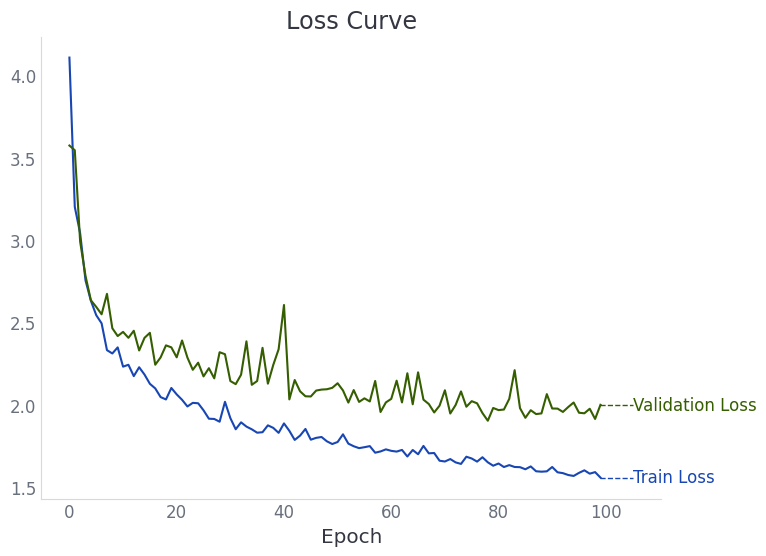

In [18]:
hist_df = pd.DataFrame(hist).set_index('Epoch')
hist_df.plot()
rp.line_labels()
plt.title('Loss Curve');


R2: 	 66.84%
MAE:	  1.057
RMSE:	  1.415


/home/nicholas/anaconda3/envs/aviary/lib/python3.10/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Text(0, 0.5, 'True')

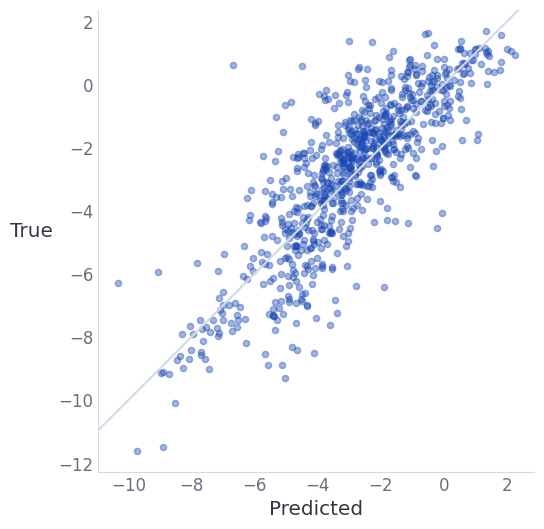

In [19]:
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error


val_trues = val_trues_tens.cpu().detach().numpy()
val_preds = val_preds_tens.cpu().detach().numpy()

print()
print(f'R2: \t{r2_score(val_trues, val_preds):7.2%}')
print(f'MAE:\t{mean_absolute_error(val_trues, val_preds):7.3f}')
print(f'RMSE:\t{mean_squared_error(val_trues, val_preds, squared=False):7.3f}')

fig, ax = plt.subplots(figsize=(6, 6))
ax.scatter(val_preds, val_trues, alpha=0.4, s=20)
ax.set_aspect('equal')
ax.axline((0, 0), slope=1, color=plt.rcParams['axes.edgecolor'])
ax.set_xlabel('Predicted')
ax.set_ylabel('True', rotation='horizontal', ha='right')

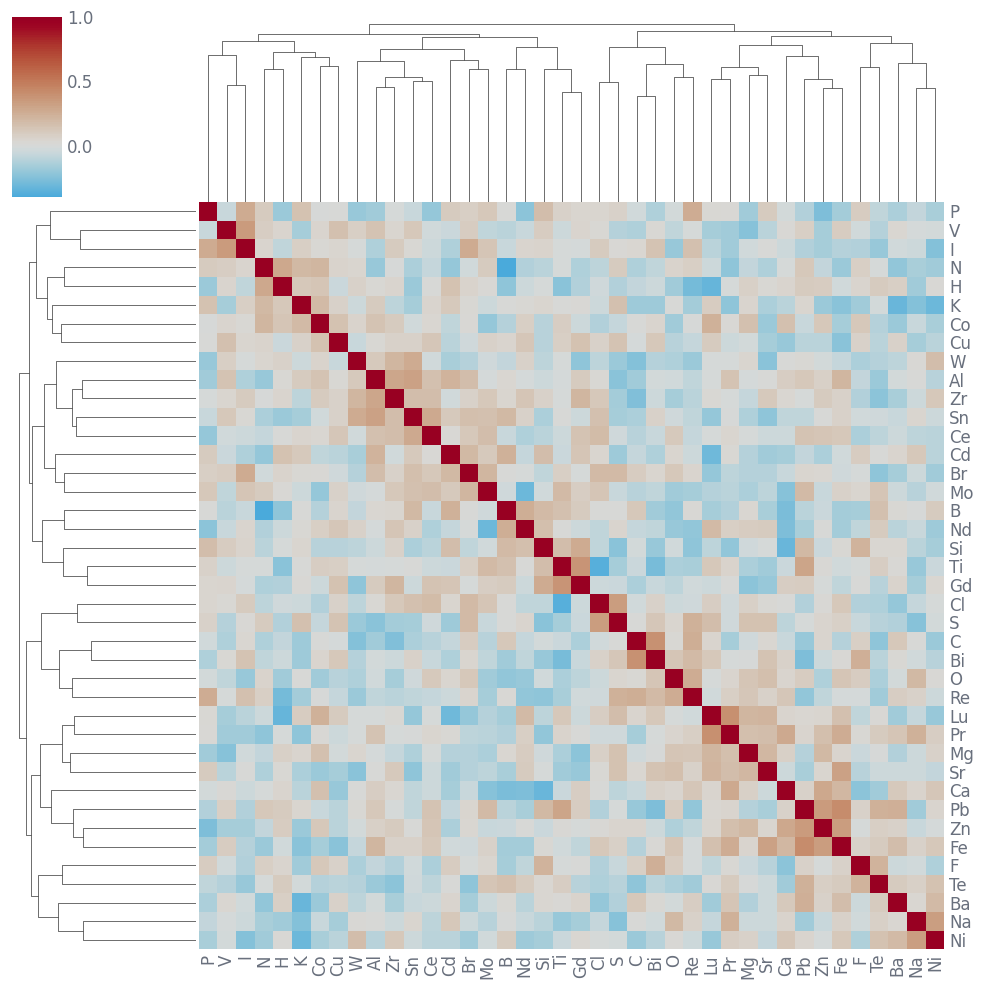

In [20]:
embed_df = pd.DataFrame(model.embed.weight.cpu().detach().numpy(), index=dataset.atoms()).T.corr()
sns.clustermap(embed_df.iloc[:40, :40], cmap='rho_diverging', center=0, xticklabels=1, yticklabels=1)